In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, precision_recall_fscore_support
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import ParameterGrid
#SMOTE
!pip install imbalanced-learn
from imblearn.over_sampling import SMOTE
#Mô hình XG Boost
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

#Random Forest
from sklearn.ensemble import RandomForestClassifier

#Decision tree
from sklearn.tree import DecisionTreeClassifier

from scipy.stats import chi2_contingency, spearmanr, skew

**A.DATA CHECKING**

In [11]:
data=pd.read_csv('/content/drive/MyDrive/Datasets/Taiwanese-Bankruptcy-Prediction.csv')
data = data.drop(columns=[' Net Income Flag'])
data

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Liability-Assets Flag,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,0.035490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6814,0,0.493687,0.539468,0.543230,0.604455,0.604462,0.998992,0.797409,0.809331,0.303510,...,0,0.799927,0.000466,0.623620,0.604455,0.840359,0.279606,0.027064,0.566193,0.029890
6815,0,0.475162,0.538269,0.524172,0.598308,0.598308,0.998992,0.797414,0.809327,0.303520,...,0,0.799748,0.001959,0.623931,0.598306,0.840306,0.278132,0.027009,0.566018,0.038284
6816,0,0.472725,0.533744,0.520638,0.610444,0.610213,0.998984,0.797401,0.809317,0.303512,...,0,0.797778,0.002840,0.624156,0.610441,0.840138,0.275789,0.026791,0.565158,0.097649
6817,0,0.506264,0.559911,0.554045,0.607850,0.607850,0.999074,0.797500,0.809399,0.303498,...,0,0.811808,0.002837,0.623957,0.607846,0.841084,0.277547,0.026822,0.565302,0.044009


In [ ]:
#Dữ liệu không có Null
for i in data.columns:
  print(i, data[i].isnull().sum())

Bankrupt? 0
 ROA(C) before interest and depreciation before interest 0
 ROA(A) before interest and % after tax 0
 ROA(B) before interest and depreciation after tax 0
 Operating Gross Margin 0
 Realized Sales Gross Margin 0
 Operating Profit Rate 0
 Pre-tax net Interest Rate 0
 After-tax net Interest Rate 0
 Non-industry income and expenditure/revenue 0
 Continuous interest rate (after tax) 0
 Operating Expense Rate 0
 Research and development expense rate 0
 Cash flow rate 0
 Interest-bearing debt interest rate 0
 Tax rate (A) 0
 Net Value Per Share (B) 0
 Net Value Per Share (A) 0
 Net Value Per Share (C) 0
 Persistent EPS in the Last Four Seasons 0
 Cash Flow Per Share 0
 Revenue Per Share (Yuan ¥) 0
 Operating Profit Per Share (Yuan ¥) 0
 Per Share Net profit before tax (Yuan ¥) 0
 Realized Sales Gross Profit Growth Rate 0
 Operating Profit Growth Rate 0
 After-tax Net Profit Growth Rate 0
 Regular Net Profit Growth Rate 0
 Continuous Net Profit Growth Rate 0
 Total Asset Growth Rat

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 95 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Bankrupt?                                                 6819 non-null   int64  
 1    ROA(C) before interest and depreciation before interest  6819 non-null   float64
 2    ROA(A) before interest and % after tax                   6819 non-null   float64
 3    ROA(B) before interest and depreciation after tax        6819 non-null   float64
 4    Operating Gross Margin                                   6819 non-null   float64
 5    Realized Sales Gross Margin                              6819 non-null   float64
 6    Operating Profit Rate                                    6819 non-null   float64
 7    Pre-tax net Interest Rate                                6819 non-null   float64
 8    After-tax net Int

**B.DATA PREPROCESSING**

***Corr Matrix***

In [12]:
corr = data.corr()
corr.style.background_gradient(cmap='coolwarm')

In [13]:
#Lọc ra các cặp có giá trị corr > 0.5
corr_pairs = corr.unstack().sort_values(ascending=False)
corr_pairs = corr_pairs[corr_pairs < 1]

high_corr_pairs = corr_pairs[corr_pairs > 0.5]
high_corr_pairs = high_corr_pairs.iloc[::2]

In [14]:
#Lọc ra các giá trị corr giữa các biến đầu vào và output 'Bankrupt?'
corr_label = corr['Bankrupt?']

In [15]:
#Ở đây tiến hành các bước bao gồm: Kiểm tra các giá trị Corr cao trong ma trận:
  #Nếu là corr của biến đầu vào với Bankrupt? thì ta sẽ giữ lại
  #So sánh 2 biến có corr cao, nếu biến nào mà corr của nó với Bankrupt? thấp hơn thì sẽ được loại, ngược lại thì lưu
  #Việc này giúp 2 điều: Xóa đi 1 giá trị trong cặp biến có Corr lớn, và xóa đi giá trị ít tác động đến đầu ra

columns_to_remove = []
for col1, col2 in high_corr_pairs.index:
  if col1 == 'Bankrupt?' or col2 == 'Bankrupt?':
    continue
  else:
    # So sánh giá trị trong corr_label và chọn cột có giá trị thấp hơn để xóa
    if corr_label[col1] < corr_label[col2]:
        columns_to_remove.append(col1)
    else:
        columns_to_remove.append(col2)
print(columns_to_remove)

[' Gross Profit to Sales', ' Net Value Per Share (A)', ' Operating Gross Margin', ' Gross Profit to Sales', ' Net Value Per Share (A)', ' Net Value Per Share (B)', ' Operating Profit Per Share (Yuan ¥)', ' After-tax Net Profit Growth Rate', ' Pre-tax net Interest Rate', ' ROA(B) before interest and depreciation after tax', ' After-tax net Interest Rate', ' After-tax net Interest Rate', ' Current Liabilities/Equity', ' Current Liability to Equity', ' Net profit before tax/Paid-in capital', ' Net Income to Total Assets', ' Persistent EPS in the Last Four Seasons', ' Liability to Equity', ' ROA(A) before interest and % after tax', ' Persistent EPS in the Last Four Seasons', ' Working capitcal Turnover Rate', ' ROA(A) before interest and % after tax', ' Pre-tax net Interest Rate', ' Continuous interest rate (after tax)', ' Net Income to Total Assets', ' Current Liability to Equity', ' Current Liability to Equity', ' Net Income to Total Assets', ' Net profit before tax/Paid-in capital', ' N

In [16]:
#Lọc ra các giá trị bị trùng lặp trong columns_to_remove, giữ lại các giá trị chỉ có 1 lần
columns_to_remove = list(set(columns_to_remove))

In [17]:
len(columns_to_remove)

38

In [19]:
data = data.drop(columns=columns_to_remove)

***Spearman Correlation: Phần này bỏ qua, không thực hiện***

In [ ]:
correlation_results = []

# Duyệt qua tất cả các cột trong DataFrame
for col in data.columns:
  corr, p_value = spearmanr(data[col], data['Bankrupt?'])  # Tính Spearman Correlation
  correlation_results.append((col, corr, p_value))

# Chuyển kết quả thành DataFrame để dễ quan sát
correlation_df = pd.DataFrame(correlation_results, columns=['Feature', 'Spearman Correlation', 'p-value'])

# Hiển thị các thuộc tính có Spearman Correlation đáng kể với biến mục tiêu
correlation_df=correlation_df.sort_values(by='Spearman Correlation', ascending=False)

In [ ]:
#Các columns nào có giá trị sẽ được giữ lại (Spearman Correlation và p-value thấp; hoặc Spearman Correlation thấp và p-value thấp)
correlation_df

,Feature,Spearman Correlation,p-value
0,Bankrupt?,1.000000,0.000000e+00
19,Total debt/Total net worth,0.219323,4.647526e-75
20,Debt ratio %,0.217237,1.221662e-73
22,Borrowing dependency,0.215094,3.388111e-72
50,Current Liability to Current Assets,0.189552,3.463837e-56
51,Liability-Assets Flag,0.139212,7.392576e-31
6,Interest-bearing debt interest rate,0.116011,7.214399e-22
31,Allocation rate per person,0.092368,2.132127e-14
38,Long-term Liability to Current Assets,0.092147,2.458494e-14
41,Total expense/Assets,0.081924,1.242401e-11


In [ ]:
data = data.drop(columns = [' Current Asset Turnover Rate', ' Fixed Assets Turnover Frequency', ' Quick Asset Turnover Rate',
                             ' Average Collection Days', ' Cash Turnover Rate', ' Revenue per person', ' Inventory Turnover Rate (times)',
                             ' Operating Expense Rate', ' Net Worth Turnover Rate (times)', ' Accounts Receivable Turnover',
                             ' Current Liability to Liability', ' Current Liabilities/Liability', ' Research and development expense rate',
                             ' Inventory/Working Capital', ' Inventory/Current Liability', ' Revenue Per Share (Yuan ¥)', ' Cash Flow to Liability',
                             ' Total Asset Growth Rate', ' Cash Flow to Equity', ' Cash Reinvestment %', ' Realized Sales Gross Profit Growth Rate',
                             ' Cash Flow to Sales', ' Operating Profit Growth Rate'])

***Vẽ biểu đồ phân phối Histogram, nhằm kiểm tra xem liệu data có phân phối chuẩn không***

*Nếu đồ thì của các biểu đồ có hình dạng bell-shaped thì có thể coi là gần chuẩn và áp dụng Standard Scaler*

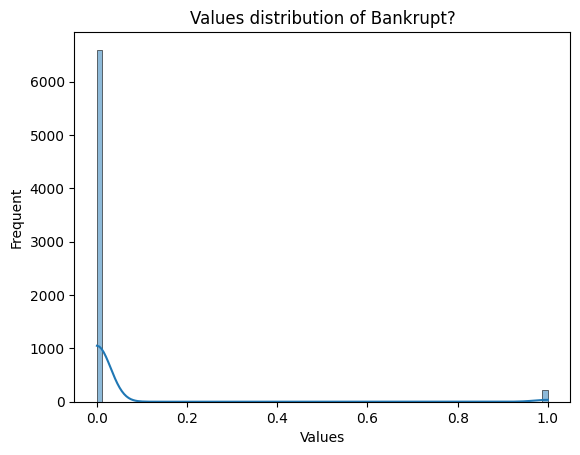

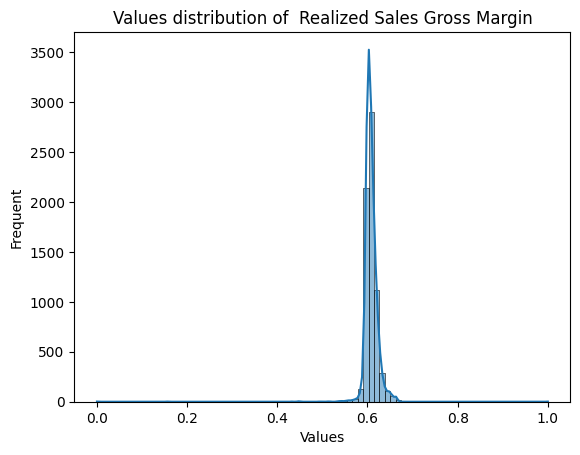

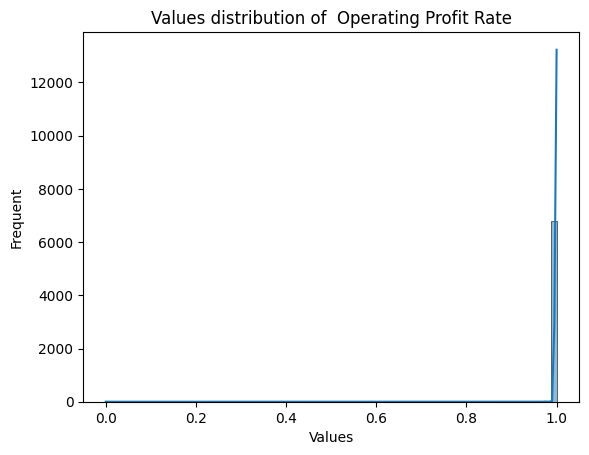

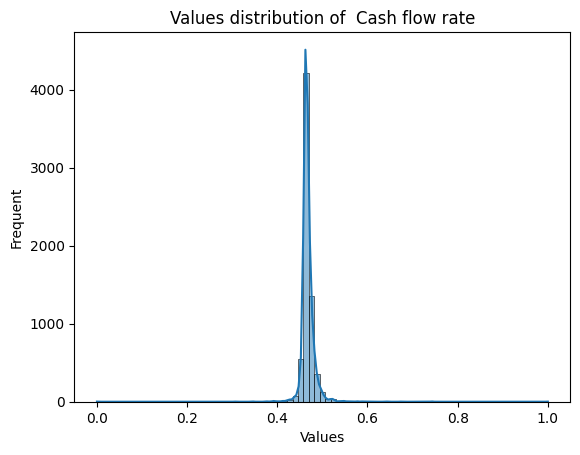

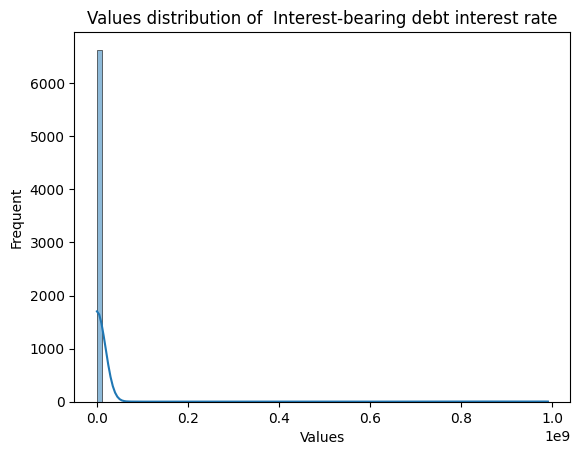

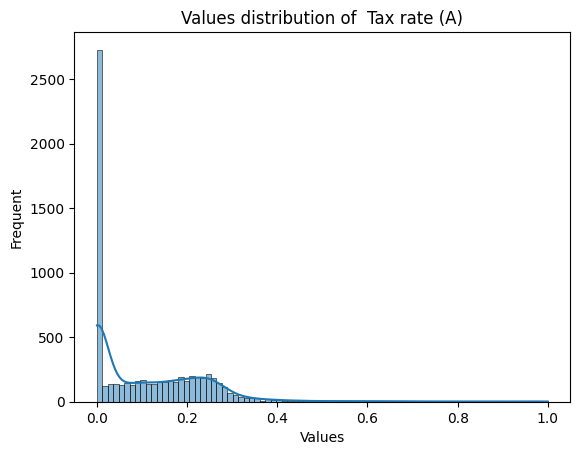

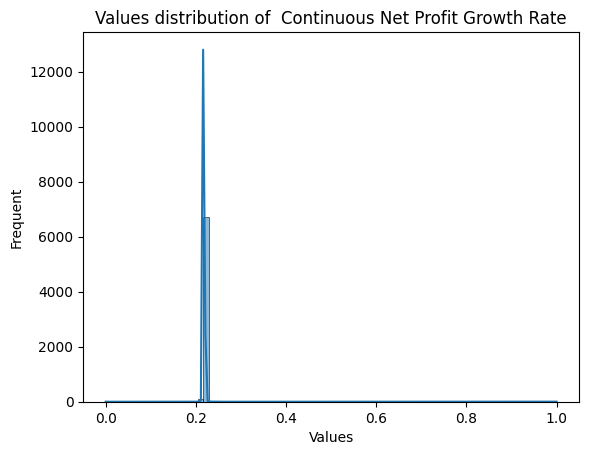

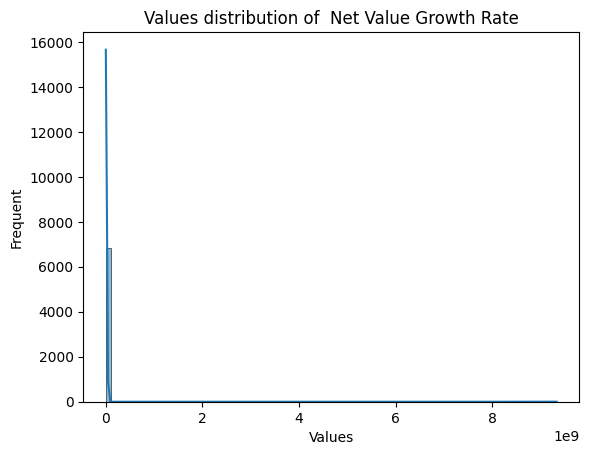

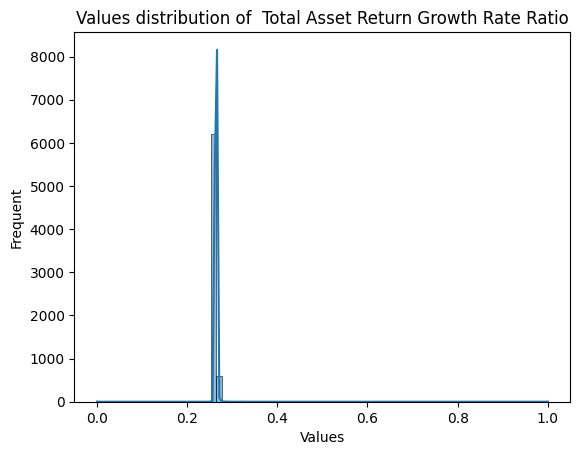

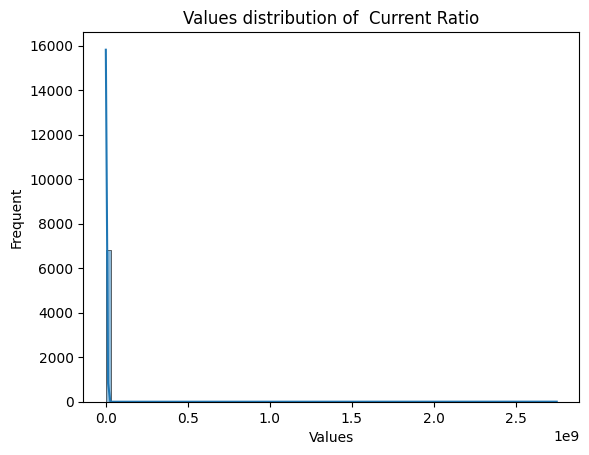

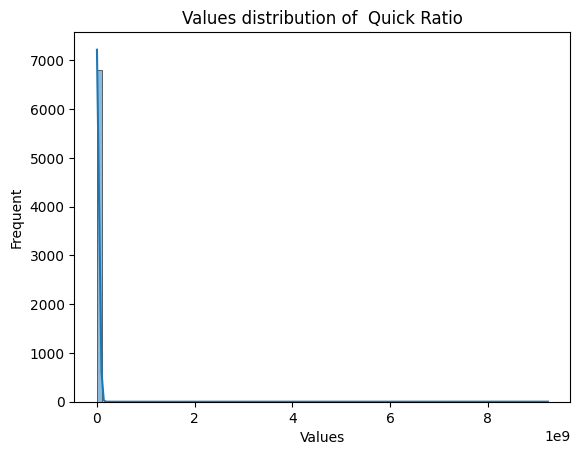

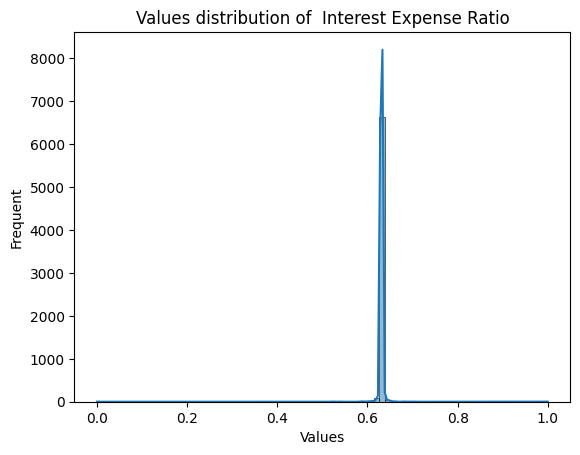

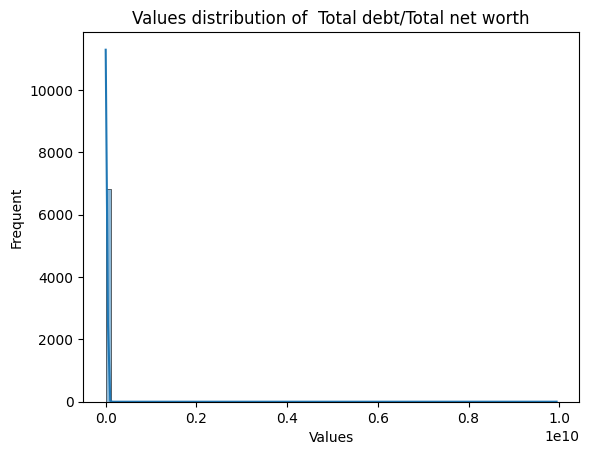

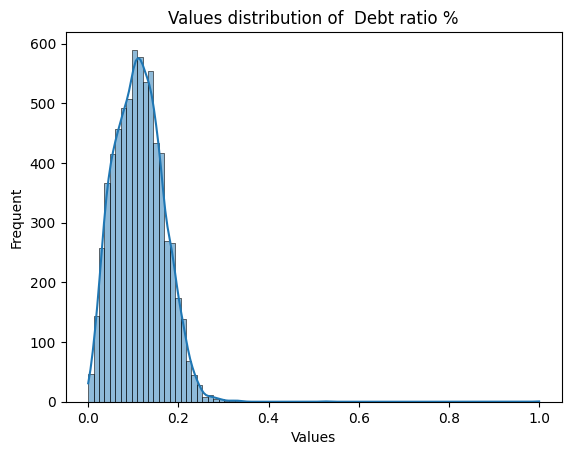

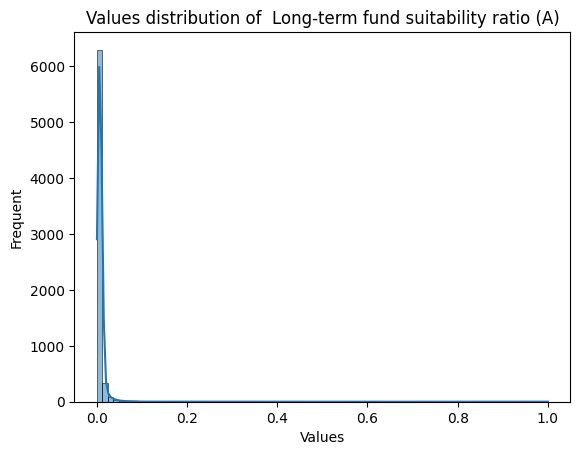

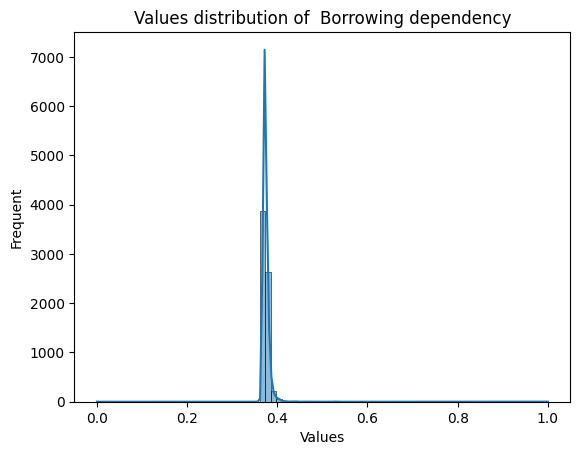

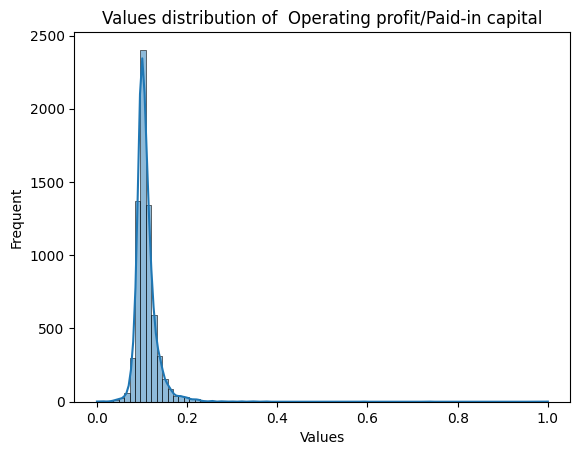

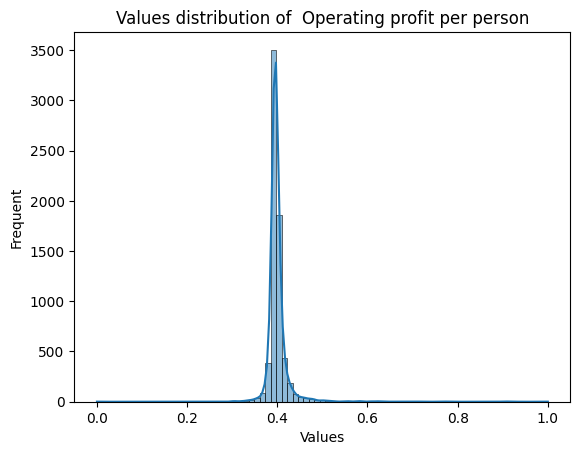

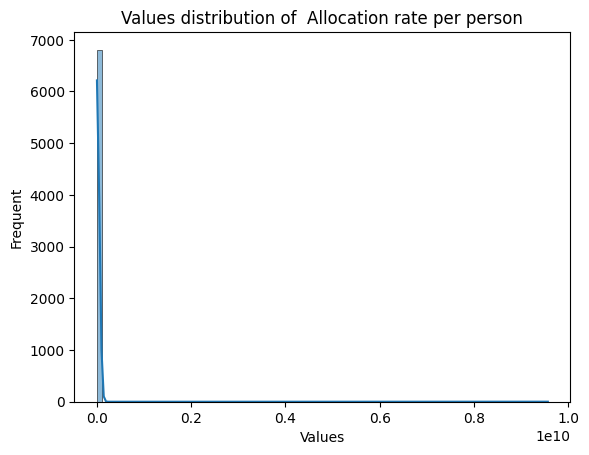

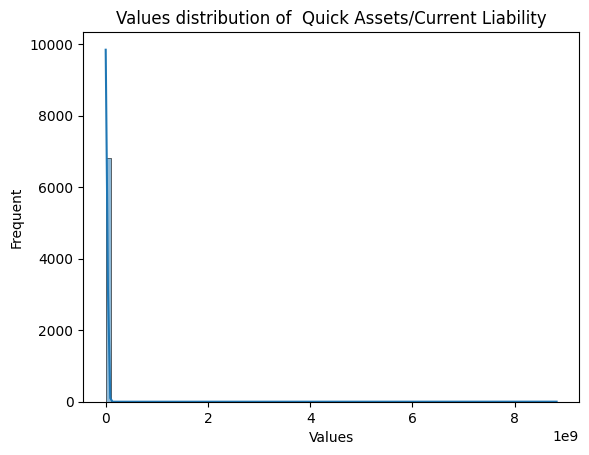

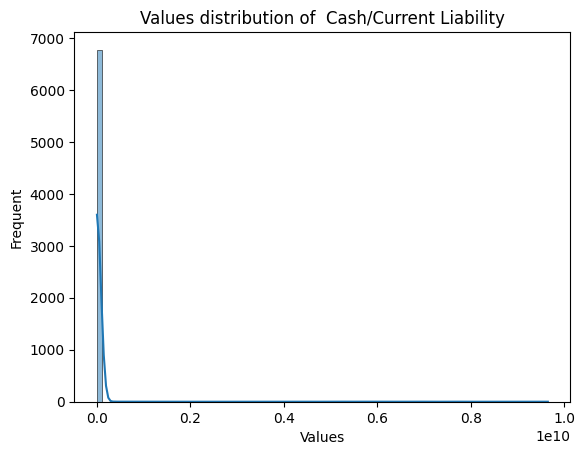

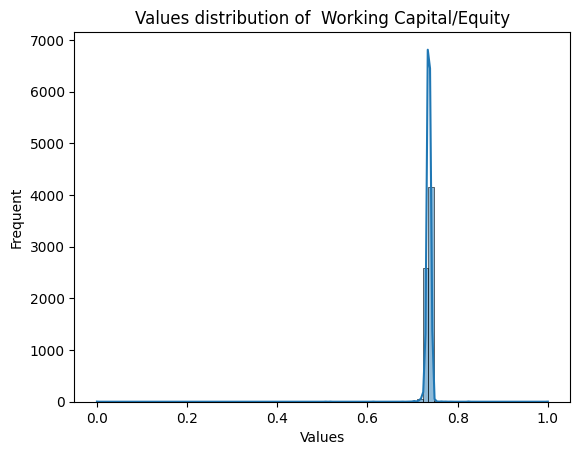

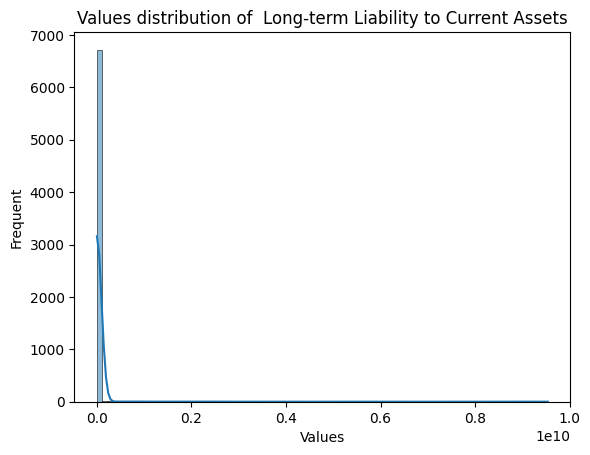

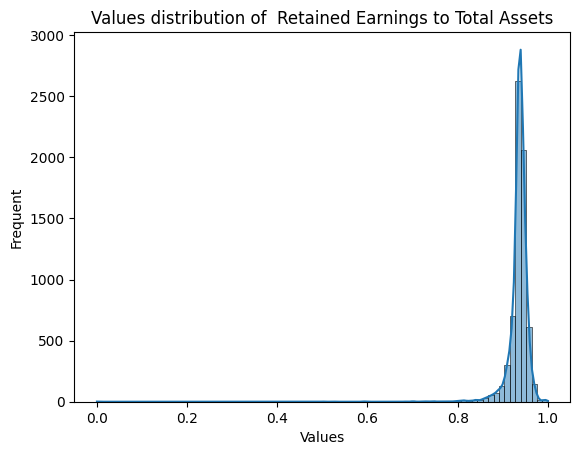

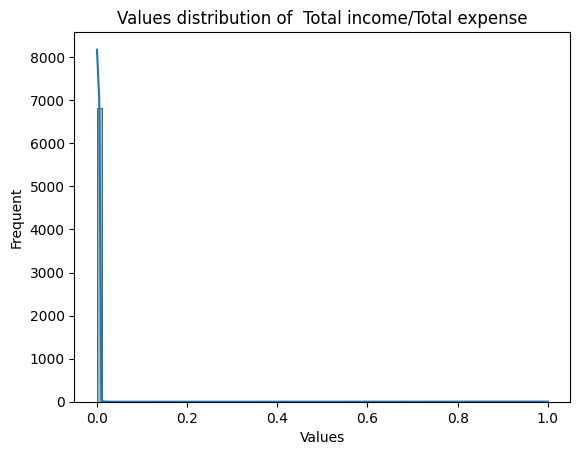

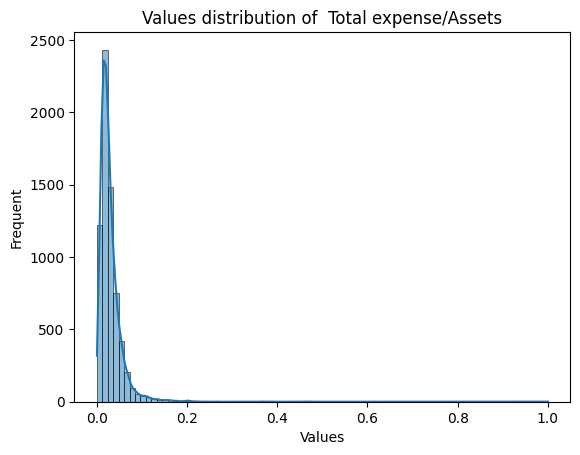

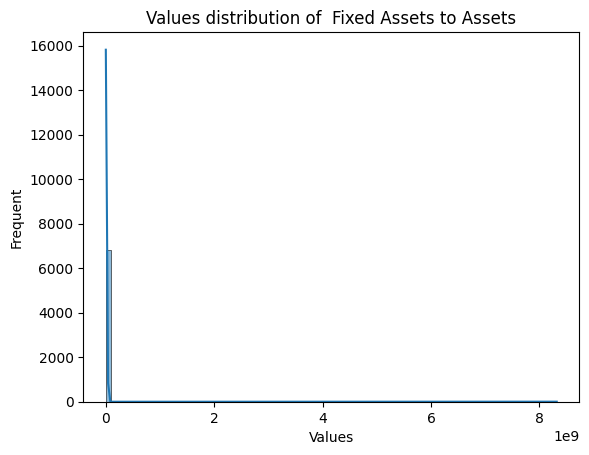

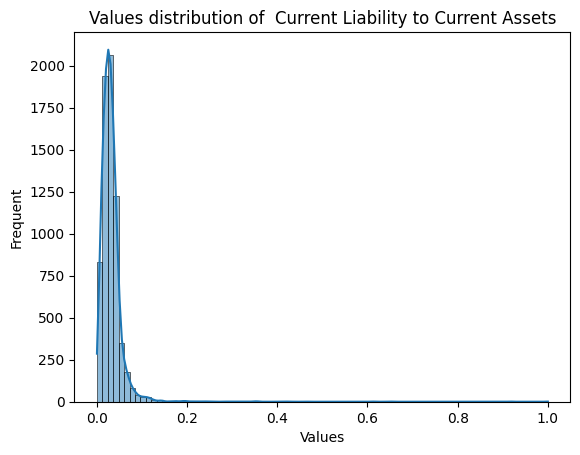

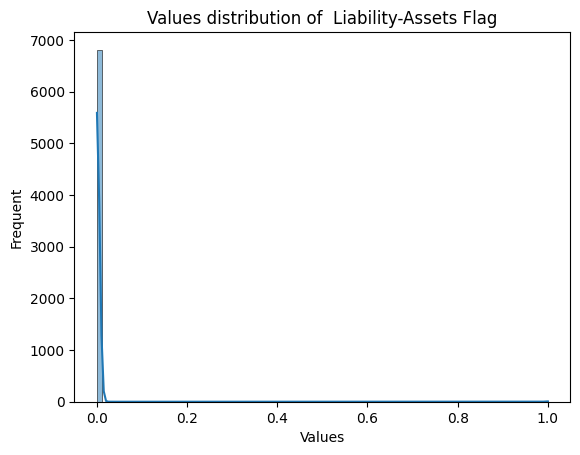

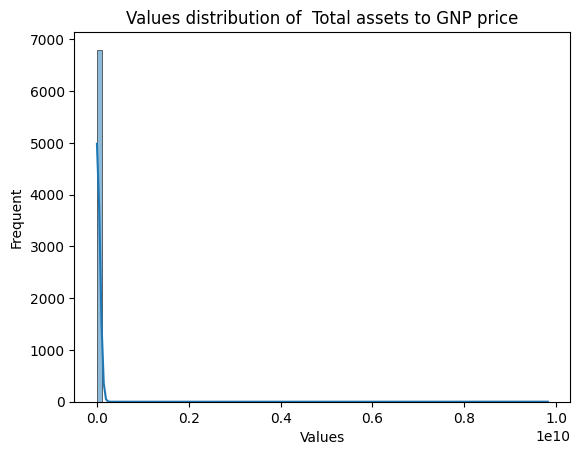

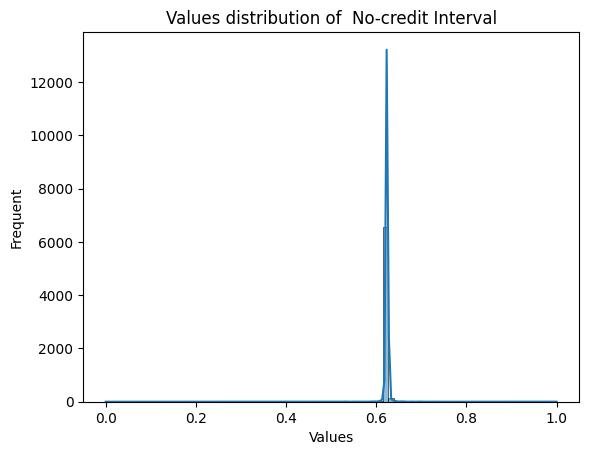

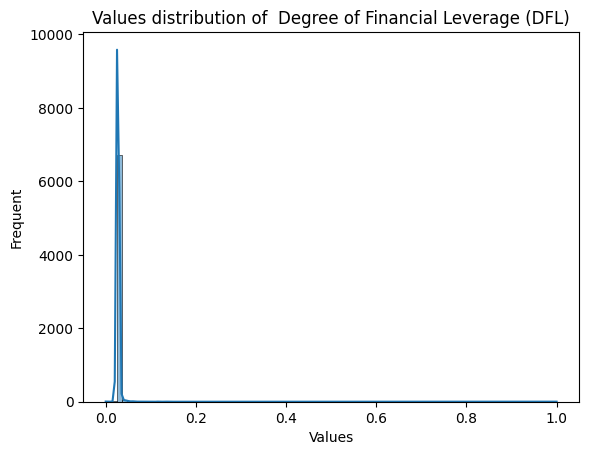

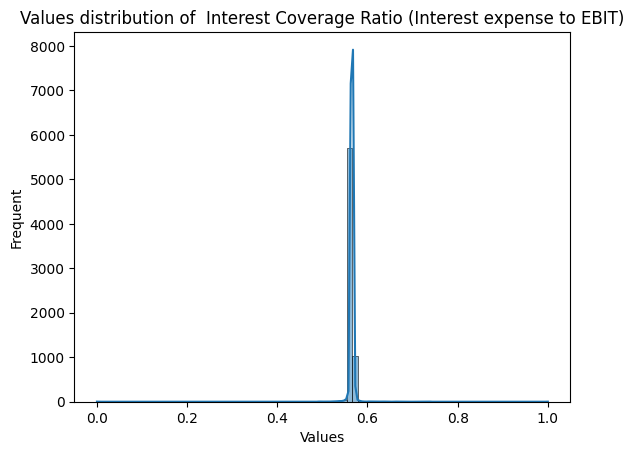

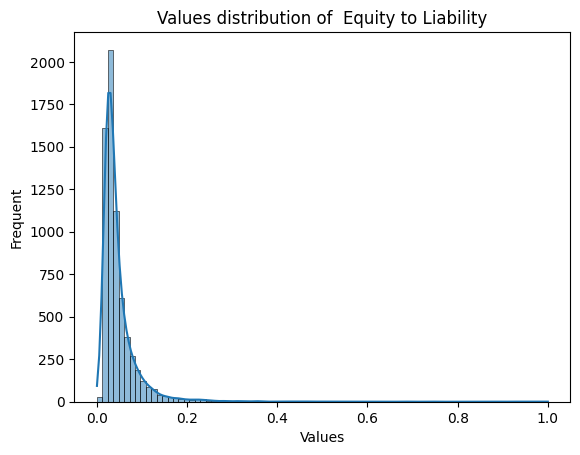

In [ ]:
for j in data.columns:
  sns.histplot(data=data[j], bins=83, kde=True)
  plt.title(f'Values distribution of {j}')
  plt.xlabel('Values')
  plt.ylabel('Frequent')
  plt.show()

**C.KIỂM TRA VỚI CÁC MÔ HÌNH**

In [21]:
#Hàm đánh giá hiệu suất
def print_scores(y_test, y_pred):
  print(classification_report(y_test, y_pred))

In [22]:
#Hàm chia tập train-test và MinMax Scaler
def preprocess_data(df, test_size=0.2, random_state=42):

    # Chia tập train-test
    X = df.drop(columns=['Bankrupt?'], axis=1)
    y = df['Bankrupt?']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # MinMax Scaler
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    return X_train, X_test, y_train, y_test

***1.Random Forest***

In [23]:
X_train, X_test, y_train, y_test = preprocess_data(data)

model_RF= RandomForestClassifier(n_estimators=200, random_state=42)
model_RF.fit(X_train, y_train)

y_train_pred = model_RF.predict(X_train)
y_test_pred = model_RF.predict(X_test)

print_scores(y_train, y_train_pred)
print_scores(y_test, y_test_pred)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5286
           1       1.00      1.00      1.00       169

    accuracy                           1.00      5455
   macro avg       1.00      1.00      1.00      5455
weighted avg       1.00      1.00      1.00      5455

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1313
           1       1.00      0.12      0.21        51

    accuracy                           0.97      1364
   macro avg       0.98      0.56      0.60      1364
weighted avg       0.97      0.97      0.95      1364



***2.Decision Tree***

In [24]:
X_train, X_test, y_train, y_test = preprocess_data(data)

model_tree = DecisionTreeClassifier()
model_tree.fit(X_train, y_train)

y_train_pred = model_tree.predict(X_train)
y_test_pred = model_tree.predict(X_test)

print_scores(y_train, y_train_pred)
print_scores(y_test, y_test_pred)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5286
           1       1.00      1.00      1.00       169

    accuracy                           1.00      5455
   macro avg       1.00      1.00      1.00      5455
weighted avg       1.00      1.00      1.00      5455

              precision    recall  f1-score   support

           0       0.97      0.98      0.98      1313
           1       0.35      0.29      0.32        51

    accuracy                           0.95      1364
   macro avg       0.66      0.64      0.65      1364
weighted avg       0.95      0.95      0.95      1364



***3.XGBOOST***

*Hiệu suất có vẻ khả quan hơn một chút, tuy nhiên vẫn có sự chênh lệch giữa Prediction và Recall*

In [25]:
#XGBOOST
X_train, X_test, y_train, y_test = preprocess_data(data)

model_XGB = xgb.XGBClassifier(random_state=42, n_estimators = 200)
model_XGB.fit(X_train, y_train)

y_train_pred = model_XGB.predict(X_train)
y_test_pred = model_XGB.predict(X_test)

print_scores(y_train, y_train_pred)
print_scores(y_test, y_test_pred)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5286
           1       1.00      1.00      1.00       169

    accuracy                           1.00      5455
   macro avg       1.00      1.00      1.00      5455
weighted avg       1.00      1.00      1.00      5455

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1313
           1       0.60      0.24      0.34        51

    accuracy                           0.97      1364
   macro avg       0.79      0.61      0.66      1364
weighted avg       0.96      0.97      0.96      1364



***4.SMOTE***

*Có vẻ ổn hơn so với 3 mô hình trên*

In [37]:
X_train, X_test, y_train, y_test = preprocess_data(data)

smote = SMOTE(random_state=42)
X_train_resample, y_train_resample = smote.fit_resample(X_train,y_train)

In [38]:
#Random Forest sử dụng SMOTE
model_RF2 = RandomForestClassifier(n_estimators=200, random_state=42)
model_RF2.fit(X_train_resample, y_train_resample)

y_train_pred = model_RF2.predict(X_train_resample)
y_test_pred = model_RF2.predict(X_test)

print_scores(y_train_resample, y_train_pred)
print_scores(y_test, y_test_pred)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5286
           1       1.00      1.00      1.00      5286

    accuracy                           1.00     10572
   macro avg       1.00      1.00      1.00     10572
weighted avg       1.00      1.00      1.00     10572

              precision    recall  f1-score   support

           0       0.98      0.97      0.98      1313
           1       0.40      0.49      0.44        51

    accuracy                           0.95      1364
   macro avg       0.69      0.73      0.71      1364
weighted avg       0.96      0.95      0.96      1364



***CẢI TIẾN SMOTE***

In [42]:
X_train, X_test, y_train, y_test = preprocess_data(data)

smote = SMOTE(random_state=42)
X_train_resample, y_train_resample = smote.fit_resample(X_train, y_train)

In [43]:
# Định nghĩa các tham số cho RandomizedSearchCV
param_grids = {
    'n_estimators': [100, 120],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [None, 10, 20]
}

# Khởi tạo mô hình Random Forest
model_RF3 = RandomForestClassifier(n_estimators=200, random_state=42)

# Tìm kiếm siêu tham số tốt nhất
grid_search = RandomizedSearchCV(estimator=model_RF3,
                                 param_distributions=param_grids,
                                 n_iter=10,
                                 cv=5,
                                 scoring='f1_weighted',
                                 random_state=42)
grid_search.fit(X_train_resample, y_train_resample)

# Lấy mô hình tốt nhất và in ra các tham số tốt nhất
best_params = grid_search.best_estimator_.get_params()
print(f"Best estimator is: {best_params}")

# Dự đoán trên tập train và test bằng mô hình tốt nhất
y_train_pred = grid_search.best_estimator_.predict(X_train_resample)
y_test_pred = grid_search.best_estimator_.predict(X_test)

# In ra các kết quả đánh giá mô hình
print_scores(y_train_resample, y_train_pred)
print_scores(y_test, y_test_pred)

Best estimator is: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 120, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5286
           1       1.00      1.00      1.00      5286

    accuracy                           1.00     10572
   macro avg       1.00      1.00      1.00     10572
weighted avg       1.00      1.00      1.00     10572

              precision    recall  f1-score   support

           0       0.98      0.97      0.97      1313
           1       0.38      0.49      0.43        51

    accuracy                           0.95      1364
   macro avg       0.68      0.73      0.70  